In [46]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures  # generate polynomial features e.g. [1, a, b, a2, ab, b2]

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  # Ordinary Least Squares (by SVD) method
from sklearn.linear_model import SGDRegressor  # Stochastic Gradient Descent method
from sklearn.linear_model import Ridge  # OLS method L2 regularisation
from sklearn.linear_model import Lasso  # OLS method L1 regularisation
from sklearn.linear_model import ElasticNet  # mix (ratio'd avg) of L1 & L2 terms
from sklearn.linear_model import LogisticRegression  # linear model at its base, comes default with L2 reg

from sklearn.metrics import mean_squared_error


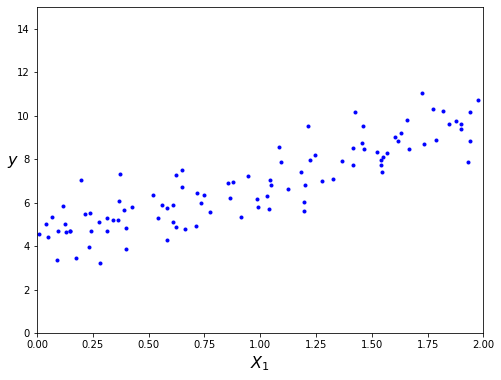

In [2]:
# simulate y = 3x + 4 + Gaussian noise
np.random.seed(42)
X_1 = 2 * np.random.rand(100, 1)  # X_0 is all ones, 100 data points
y   = 4 + 3 * X_1 + np.random.randn(100, 1)

plt.figure(figsize=(8, 6))
plt.plot(X_1, y, 'b.')  # same as scatter plot with '.'
plt.axis([0, 2, 0, 15])
plt.xlabel('$X_1$', fontsize=16),
plt.ylabel('$y$', fontsize=16, rotation=0);

In [3]:
# Closed-form linear regression by Normal Equation:
# theta = (X_T.X)^(-1).X_T.y
X_0 = np.ones(shape=(100, 1))  # dummy variable with intercept parameter theta_0
X = np.c_[X_0, X_1]  # add x0 = 1 to each instance

theta_best_ne = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_best_ne  # [theta_0, theta_1] in 2 x 1 column vector

array([[4.21509616],
       [2.77011339]])

In [4]:
# Closed-form linear regression by OLS, Ordinary Least Squares:
theta_best_ols, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
theta_best_ols

array([[4.21509616],
       [2.77011339]])

In [5]:
# OLS basically uses SVD, singular value decomposition
# X.theta=y -> theta=X_pseudoinv.y -> decompose X_pseudoinv
np.linalg.pinv(X).dot(y)

array([[4.21509616],
       [2.77011339]])

In [6]:
# OLS (SVD) is what sklearn LinearRegression() uses to compute parameters theta
lin_reg = LinearRegression()
lin_reg.fit(X_1, y)  # no need to include the dummy intercept x0 vector
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [7]:
# gradient descent SGDRegressor() is faster than ordinary LinearRegression()
# stochastic gradient descent:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)  # iterative, loss tolerance, learning rate
sgd_reg.fit(X_1, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.2105325]), array([2.77484204]))

In [8]:
# batch gradient descent (for 100 data points):
eta = 0.1  # learning rate
n_iterations = 1000
m = 100  # number of data points as used above

theta = np.random.randn(2, 1)  # random initial guess of intercept & coef theta

for iteration in range(n_iterations):
    gradients = 2 / m * X.T.dot(X.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

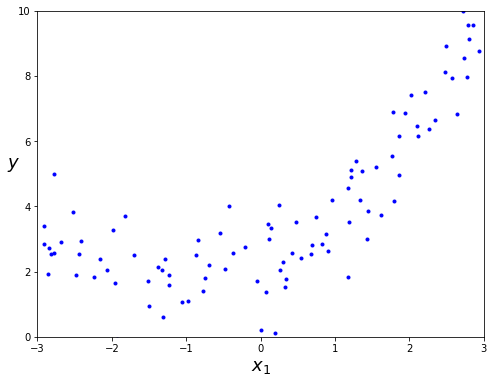

In [9]:
# polynomial equation
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)  # quadratic

plt.figure(figsize=(8, 6))
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10]);

In [10]:
# polynomial regression (~mapping polynomial to linear regression)

# step-1: transform variables to polynomial:
poly_features = PolynomialFeatures(degree=2, include_bias=False)  # quadratic, no intercept (1) term
X_poly = poly_features.fit_transform(X)  # transform each x to [x, x2]
X_poly[:5]  # [x, x2] for each data point

array([[-4.48938371e-02,  2.01545661e-03],
       [-1.82854207e+00,  3.34356611e+00],
       [ 1.33471269e+00,  1.78145797e+00],
       [-1.31536583e+00,  1.73018725e+00],
       [-2.85410420e+00,  8.14591079e+00]])

In [11]:
X[:5]

array([[-0.04489384],
       [-1.82854207],
       [ 1.33471269],
       [-1.31536583],
       [-2.8541042 ]])

In [12]:
# step-2: fit linear regression to transformed polynomial features (x & x2):
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.13145886]), array([[1.04692782, 0.49909642]]))

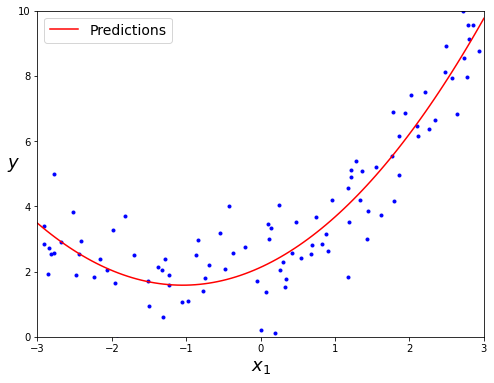

In [13]:
# order X for plot of a curve
X_ordered = np.linspace(-3, 3, 100).reshape(100, 1)  # reshape to 100 x 1 array!
X_ordered_poly = poly_features.fit_transform(X_ordered)
y_hat = lin_reg.predict(X_ordered_poly)

plt.figure(figsize=(8, 6))
plt.plot(X, y, 'b.')
plt.plot(X_ordered, y_hat, 'r-', label="Predictions")

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(fontsize=14)
plt.axis([-3, 3, 0, 10]);

In [14]:
# learning curves plot - to see performance improvement trend over more and more training data
def plot_training_curves(model, X, y):
    # set aside a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)  
    train_errors, test_errors = [], []
    # calculate performance metrics for each subset of the training set
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])  # train an increasing training set,
        y_test_predict = model.predict(X_test)  # but test on the same test set,
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))  
    # plot the test RMSE vs. different training subset RMSE
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")   
    plt.xlabel("Training (sub)set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.legend(fontsize=14)

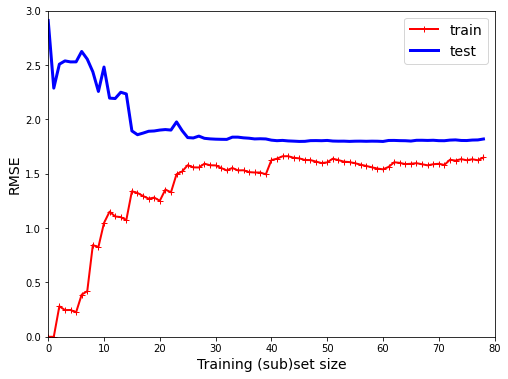

In [15]:
# typical plot for an underfit model (by tempting to fit a quadratic function with a linear relationship)
lin_reg = LinearRegression()

plt.figure(figsize=(8, 6))
plot_training_curves(lin_reg, X, y)  # data from above: y ~ quadratic(X)
plt.axis([0, 80, 0, 3]);

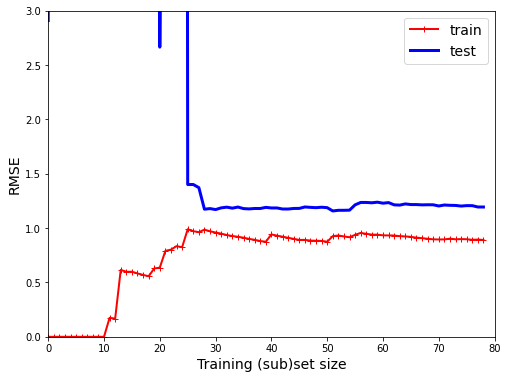

In [17]:
# typical plot for an overfit model (by fit_transform too high degree polynomial features)
poly_reg = Pipeline([
    ('poly_feat', PolynomialFeatures(degree=10, include_bias=False)),  # ideal degree is 2, i.e. quadratic
    ('lin_reg', LinearRegression())
])

plt.figure(figsize=(8, 6))
plot_training_curves(poly_reg, X, y)
plt.axis([0, 80, 0, 3]);

In [19]:
# Ridge / Lasso regression are variations of linear (or adapted polynomial) regression
# OLS approach (similar to direct LinearRegression class):
ridge_reg = Ridge(alpha=1, solver='cholesky')  # closed-form solver
ridge_reg.fit(X, y)

Ridge(alpha=1, solver='cholesky')

In [23]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)

Lasso(alpha=0.1)

In [25]:
# SGD approach:
sgd_ridge_reg = SGDRegressor(penalty='l2')  # Ridge
sgd_ridge_reg.fit(X, y.ravel())

SGDRegressor()

In [24]:
sgd_lasso_reg = SGDRegressor(penalty='l1')  # Lasso
sgd_lasso_reg.fit(X, y.ravel())

SGDRegressor(penalty='l1')

In [27]:
# mix of both Ridge and Lasso with ElasticNet:
elastic_net_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)  # half Lasso, also half Ridge
elastic_net_reg.fit(X, y)

ElasticNet(alpha=0.1)

In [28]:
sgd_en_reg = SGDRegressor(l1_ratio=0.5)  # as above
sgd_en_reg.fit(X, y.ravel())

SGDRegressor(l1_ratio=0.5)

In [30]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [45]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [42]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [48]:
X = iris['data'][:, 3:]  # column 3 is petal width - but need to form a 2D array
y = (iris['target'] == 2).astype(int)  # if is virginica (0's for no and 1's for yes)

In [49]:
log_reg = LogisticRegression()  # penalty='l2', i.e. this is regularised by default
log_reg.fit(X, y)

LogisticRegression()

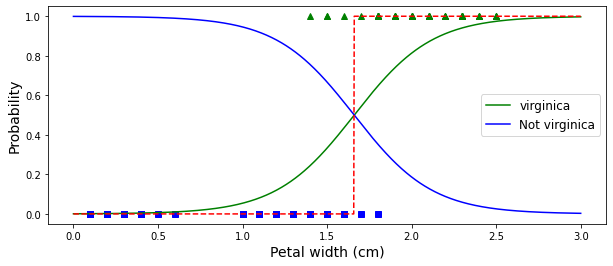

In [64]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)  # logit values between 0 and 1
y_label = log_reg.predict(X_new)  # decision: 0 or 1 (the larger logit value wins)

plt.figure(figsize=(10, 4))

# actual data points
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
# predicted logit values with boundary line at logit = 0.5
plt.plot(X_new, y_proba[:, 1], 'g-', label='virginica')      # 1 column logit values ->
plt.plot(X_new, y_proba[:, 0], 'b-', label='Not virginica')  # 0 column logit values -> sum equals 1
# decision boundary
plt.plot(X_new, y_label, 'r--')

plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(fontsize=12);

In [65]:
# by default, LogisticRegresssion() uses "OvR" for multiclass
# but, can also switch to use Softmax:
X_multi = iris['data'][:, (2, 3)]
y_multi = iris['target']  # 3 classes

softmax_reg = LogisticRegression(multi_class='multinomial',  # softmax ('multinomial') or 'ovr'
                                 solver='lbfgs',  # compatible solver algorithm
                                 C=10)  # l2 penalty parameter
softmax_reg.fit(X_multi, y_multi)

LogisticRegression(C=10, multi_class='multinomial')

In [66]:
softmax_reg.predict_proba([[5, 2]])  # [patel length, patel width]

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

In [67]:
softmax_reg.predict([[5, 2]])  # class 2 has the largest logit value

array([2])